In [62]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
## Comment in this script is follwoing doxygen style in case it is needed to export in Latex. ref: https://www.doxygen.nl/manual/docblocks.html#pythonblocks
## general path config
gen_path = '/content/drive/MyDrive/Job'
proj_name = 'Fracta_test'
proj_path = os.path.join(gen_path, proj_name) # current location
plot_path = os.path.join(proj_path, 'plots') # plot output by EDA or ML
data_path = os.path.join(proj_path, 'data') # raw data path
output_path = os.path.join(proj_path, 'output') # output path

# GM Data loading

In [64]:
## load data
gm_name = 'GM2022_assets.csv'
gm_path = os.path.join(data_path, gm_name)
gm_df = pd.read_csv(gm_path, encoding = "cp932") # encoding option for reading Japanese. ref: https://docs.python.org/3/library/codecs.html#standard-encodings

## Check data shape
print(gm_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(gm_df.info())
print('# of duplicated rows:', gm_df.duplicated().sum())

| GID       | 管種   | 埋設年   | Shape_LENGTH   | 口径   | 活用状況   | soil_ph   | mean_low_temp   | soil_moisture_index   |
|:----------|:-------|:---------|:---------------|:-------|:-----------|:----------|:----------------|:----------------------|
| WM09952-D | DUC(K) | S63.12   | 24.6183        | 10     | True       | 7.60746   | 4.92414         | 6.35588               |
| WM02595-P | CIP    | S29.7    | 514.016        | 10     | True       | 7.99887   | 5.73829         | 7.58934               |
| WM04638-C | CIP    | S11.1    | 447.748        | 6      | True       | 8.27867   | 5.19317         | 5.6778                |
| WM02974-D | DUC(G) | S55.2    | 120.439        | 14     | True       | 6.40976   | 6.15492         | 3.54707               |
| WM08449-D | DUC(K) | H28.9    | 0.0186696      | 10     | True       | 7.11469   | 8.41889         | 4.16761               |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 9 columns):
 #   Column     

# GM Data Cleaning

# Rename column name to English

| Japanese | English |
| :-: | :-: |
| GID | native_pipe_id |
| 管種 | material_original |
| 埋設年 | install_year_original |
| 口径 | diameter |
| 活用状況 | usage_status |

This is unnecessary step. It is done for consistancy of the table.

The `管種` is named to `material_original`. The Fracta standard name will be saved in `material` after the conversion based on the instruction.

The `埋設年` is calculated in Japanese era standard. I named it `install_year_original` in order to save the converted Gregorian version as an `install_year`.

In [65]:
## rename column to english
## this is unnecessary step. It is done for consistancy of the table
col_dict = {'GID':'native_pipe_id', '管種':'material_original',
            '埋設年':'install_year_original', '口径':'diameter', '活用状況':'usage_status'}
gm_df.rename(columns = col_dict, inplace = True)
gm_df.columns = map(str.lower, gm_df.columns) # little bit of consistancy

## check the rename results
print(gm_df.columns)

Index(['native_pipe_id', 'material_original', 'install_year_original',
       'shape_length', 'diameter', 'usage_status', 'soil_ph', 'mean_low_temp',
       'soil_moisture_index'],
      dtype='object')


All# Required cleaning

1. The `usage_status` (活用状況) is oppsite to the `abandoned` (撤去ステータス). I flipped the boolean to create the `abandoned`
2. The 管種 information in the `material_original` is renamed to following the Fracta standard and saved in the `material`.

| material_original | material | full name |
| :-: | :-: | :-: |
| DUC(K), DUC(G) | DIP | Ductile Cast Iron Pipe |
| CIP | CAS | Gray Cast Iron Pipe |
| PVC | PVC | Polyvinyl Chloride Pipe |
| ACON | AC | Asbestos Cement Pipe |
| STW, STP | SP | Steel Pipe |

3. The Japanese era in `install_year_original` is converted to Gregorians style by `jp_to_gr()` and saved in `install_year`.

# Additional engineering

1. Since information in `material_original`, `material`, and `native_pipe_id` are non-numerical format, It is not applicable for the merchine leraning process. All the columns are converted to numerical format by `LabelEncoder()` and saved in `material_original_encode`, `material_encode`, and `native_pipe_id_encode` in case it needed for ML. The `material_original_encode` is also changed in case differences between 'DUC(G)' and 'DUC(K)' are needed to be considered.


In [66]:
## converts usage_status (活用状況) to abandoned (撤去ステータス)
## Since the usage status is opposite of the abandoned, It might not need to be in the table
gm_df['abandoned'] = ~gm_df['usage_status']

## Rename material to company standard
mat_dict = {'DUC(K)':'DIP', 'DUC(G)':'DIP', 'CIP':'CAS', 'PVC':'PVC', 'ACON':'AC', 'STW':'SP', 'STP':'SP'}
gm_df['material'] = gm_df['material_original'].map(mat_dict)
"""
## alternate way to convert material names by using NumPy functions and not using the for loop
old_mat_name = np.array(['ACON', 'CIP', 'DUC(G)', 'DUC(K)', 'PVC', 'STP', 'STW'], dtype = 'object')
new_mat_name = np.array(['AC', 'CAS', 'DIP', 'DIP', 'PVC', 'SP', 'SP'], dtype = 'object')
mat_ori_np = gm_df['material_original'].to_numpy(dtype = 'object')
mat_ori_idx = np.searchsorted(old_mat_name, mat_ori_np, side = 'left')
gm_df['material'] = new_mat_name[mat_ori_idx]
"""

## converts Japanese years to Gregorians
def jp_to_gr(jp_dt):
  jp_yr_dict = {'M':1867, 'T':1911, 'S':1925, 'H':1988, 'R':2018}

  if type(jp_dt) == float: return np.nan # I will turn it to 'NULL' after EDA or ML
  jp_yr, mon = jp_dt.split('.') # There is no date information in the raw data
  gr_yr = int(jp_yr[1:]) + jp_yr_dict[jp_yr[:1]] - 1

  return f'{gr_yr:04d}-{int(mon):02d}-01' # simpler return than using datetime package
  #return datetime.date(gr_yr, int(mon), 1).strftime('%Y-%m-%d')
  ## we can also use '!pip install Japanera' for the conversion
gm_df['install_year'] = gm_df['install_year_original'].apply(jp_to_gr)

## convert material & material_original to numerical formats in case it needed for ML
label_encoder = LabelEncoder()
gm_df['material_original_encode'] = label_encoder.fit_transform(gm_df['material_original']) # I changed this too in case differences between 'DUC(G)' and 'DUC(K)' are needed to be considered
gm_df['material_encode'] = label_encoder.fit_transform(gm_df['material'])
gm_df['native_pipe_id_encode'] = label_encoder.fit_transform(gm_df['native_pipe_id'])

## middle check
gm_df.head()

,native_pipe_id,material_original,install_year_original,shape_length,diameter,usage_status,soil_ph,mean_low_temp,soil_moisture_index,abandoned,material,install_year,material_original_encode,material_encode,native_pipe_id_encode
0,WM09952-D,DUC(K),S63.12,24.618317,10.0,True,7.607464,4.924143,6.355882,False,DIP,1987-12-01,3,2,6125
1,WM02595-P,CIP,S29.7,514.015780,10.0,True,7.998868,5.738295,7.589341,False,CAS,1953-07-01,1,1,1564
2,WM04638-C,CIP,S11.1,447.747983,6.0,True,8.278671,5.193168,5.677802,False,CAS,1935-01-01,1,1,2780
3,WM02974-D,DUC(G),S55.2,120.438646,14.0,True,6.409756,6.154922,3.547069,False,DIP,1979-02-01,2,2,1788
4,WM08449-D,DUC(K),H28.9,0.018670,10.0,True,7.114687,8.418888,4.167609,False,DIP,2015-09-01,3,2,5157


# WO Data Loading

In [67]:
## load data
wo_name = 'WO_EXPORT.csv'
wo_path = os.path.join(data_path, wo_name)
wo_df = pd.read_csv(wo_path, encoding = "cp932") # encoding option for reading Japanese. ref: https://docs.python.org/3/library/codecs.html#standard-encodings

## Check data shape
print(wo_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(wo_df.info())
print('# of duplicated rows:', wo_df.duplicated().sum())

| 紐づけ管路ID   | 漏水項目              | 修繕結果   | RMINFO   | 受付日      | 登録日   |
|:---------------|:----------------------|:-----------|:---------|:------------|:---------|
| WM02656-C      | 亀裂                  | Resolved   | 1        | 2.00209e+07 | 20221114 |
| WM04742-P      | 第三者損傷            | Resolved   | 1        | 2.02106e+07 | 20221114 |
| WM00040-C      | 亀裂                  | Resolved   | 0        | 2.01306e+07 | 20221114 |
| WM12614-C      | ピンホール（5mm以下） | Resolved   | 0        | 2.00805e+07 | 20221114 |
| WM04879-A      | 亀裂                  | Resolved   | 1        | 2.01504e+07 | 20221114 |
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   紐づけ管路ID  340 non-null    object 
 1   漏水項目     333 non-null    object 
 2   修繕結果     340 non-null    object 
 3   RMINFO   340 non-null    int64  
 4   受付日      311 non-null    float64
 5   登録日      340 non-nul

# WO Data Cleaning

# Rename column name to English

| Japanese | English |
| :-: | :-: |
| 紐づけ管路ID | native_pipe_id |
| 漏水項目 | leaking_items_original |
| 修繕結果 | repair_results |
| 受付日 | receipt_date |
| 登録日 | registration_date_original |

This is unnecessary step. It is done for consistancy of the table.

The `漏水項目` is named to `leaking_items_original`. The information in the `leaking_items_original` is written in the Japanese. I translated them into the English and saved in `leaking_items`

The `登録日` is written in the int64 datatype. It is converted to data time with string format and saved in `registration_date`.

In [68]:
## rename column to english
## this is unnecessary step. It is done for consistancy of the table
col_dict = {'紐づけ管路ID':'native_pipe_id', '漏水項目':'leaking_items_original',
            '修繕結果':'repair_results', '受付日':'receipt_date', '登録日':'registration_date_original'}
wo_df.rename(columns = col_dict, inplace = True)
wo_df.columns = map(str.lower, wo_df.columns) # little bit of consistancy

## check the rename results
print(wo_df.columns)

Index(['native_pipe_id', 'leaking_items_original', 'repair_results', 'rminfo',
       'receipt_date', 'registration_date_original'],
      dtype='object')


# Required cleaning

1. The `break_date` is calculated by converting `receipt_date` into date time string format.
2. The instruction mentioned that the leakage incident should not include human-made leakage (漏水事故は自然に発生した漏水に絞る必要がある。). To take into account this, all the rows that corresponded to `第三者損傷` needed to be removed from the table.
3. I will remove them after EDA or ML for reconstruction.

# Additional engineering

1. Japanese information in the `leaking_items_original` is traslated to the English and saved in `leaking_items`

| Japanese | English |
| :-: | :-: |
| 亀裂 | crack |
| 第三者損傷 | third_party_damage |
| ピンホール（5mm以下） | pinhole_less_than_5mm |
| 継手破損 | joint_damage |
| ピンホール（5mm以上） | pinhole_more_than_5mm |
| 不明 | unknown |


2. Since information in `leaking_items` and `repair_results` are non-numerical format, It is not applicable for the merchine leraning process. Both columns are converted to numerical format by `LabelEncoder()` and saved in `leaking_items_encode` and `repair_results_encode` in case it needed for ML.

3. The `registration_date_original` is written in the int64 datatype. It is converted to date time with string format and saved in `registration_date`.

In [69]:
## converts the receipt date (受付日) to break_date
nan_idx = np.isnan(wo_df['receipt_date'])
wo_df['break_date'] = pd.to_datetime(wo_df['receipt_date'], format='%Y%m%d').astype(str)
wo_df['break_date'][nan_idx] = np.nan # I will turn it to 'NULL' after EDA or ML

## To follow this instruction, 漏水事故は自然に発生した漏水に絞る必要がある。(モデリングの観点からは、入力変数とターゲット変数の相関関係があるのが前提)。,
## All the rows that corresponeded to '第三者損傷':'third_party_damage' needed to be removed from the table.
## Let just keep the index of the 'third_party_damage' for now. I will remove them after EDA or ML for reconstruction
wo_tpd_idx = wo_df['leaking_items_original'] == '第三者損傷'

## converts leaking_items (漏水項目) to english and numerical format in case it needed for ML
item_dict = {'亀裂':'crack', '第三者損傷':'third_party_damage', 'ピンホール（5mm以下）':'pinhole_less_than_5mm',
            '継手破損':'joint_damage', 'ピンホール（5mm以上）':'pinhole_more_than_5mm', '不明':'unknown'}#, np.nan:'NULL'} # I will turn it to 'NULL' after EDA or ML
wo_df['leaking_items'] = wo_df['leaking_items_original'].map(item_dict)
wo_df['leaking_items_encode'] = label_encoder.fit_transform(wo_df['leaking_items'])

## converts repair_results (修繕結果) to numerical format in case it needed for ML
wo_df['repair_results_encode'] = label_encoder.fit_transform(wo_df['repair_results'])

## converts the registration date (登録日) to string format. Could converts to datetime format. Since break_date is string format, I will follow the string format
wo_df['registration_date'] = pd.to_datetime(wo_df['registration_date_original'], format='%Y%m%d').astype(str)

## middle check
wo_df.head()

<ipython-input-69-6f09266007e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_df['break_date'][nan_idx] = np.nan # I will turn it to 'NULL' after EDA or ML


,native_pipe_id,leaking_items_original,repair_results,rminfo,receipt_date,registration_date_original,break_date,leaking_items,leaking_items_encode,repair_results_encode,registration_date
0,WM02656-C,亀裂,Resolved,1,20020912.0,20221114,2002-09-12,crack,0,0,2022-11-14
1,WM04742-P,第三者損傷,Resolved,1,20210618.0,20221114,2021-06-18,third_party_damage,4,0,2022-11-14
2,WM00040-C,亀裂,Resolved,0,20130610.0,20221114,2013-06-10,crack,0,0,2022-11-14
3,WM12614-C,ピンホール（5mm以下）,Resolved,0,20080521.0,20221114,2008-05-21,pinhole_less_than_5mm,2,0,2022-11-14
4,WM04879-A,亀裂,Resolved,1,20150425.0,20221114,2015-04-25,crack,0,0,2022-11-14


# Exploratory data analysis (EDA) for sanity checking and filling in missing data

In this section, the quality cut was implemented by checking outlier and data distribution. The hypothesis was built on how to fill the data.

# GM EDA

1. The `install_year` is converted to time stamp and saved in `install_time_stamp`. Now we can utilize date information for analysis.
2. The data that correponded to missing rows are now saved in two new data frame for more convenient comparison.

In [70]:
## new df for EDA
gm_eda_df = gm_df.copy()

## Converts 'install_year' to unixtime (timestamp) so that I can it for analysis as a numeric format. I din't consider the timezone
gm_eda_df['install_time_stamp'] = gm_eda_df['install_year'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)

## new df for missing spot in the data
gm_time_eda_df = gm_eda_df[gm_eda_df['install_time_stamp'].isna()]
gm_dia_eda_df = gm_eda_df[gm_eda_df['diameter'].isna()]

## check the shape time should be all nan on `gm_time_eda_df` and diameter should be all nan on `gm_dia_eda_df`
print(gm_time_eda_df.info(), gm_dia_eda_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 63 to 9857
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   native_pipe_id            267 non-null    object 
 1   material_original         267 non-null    object 
 2   install_year_original     0 non-null      object 
 3   shape_length              267 non-null    float64
 4   diameter                  260 non-null    float64
 5   usage_status              267 non-null    bool   
 6   soil_ph                   267 non-null    float64
 7   mean_low_temp             267 non-null    float64
 8   soil_moisture_index       267 non-null    float64
 9   abandoned                 267 non-null    bool   
 10  material                  267 non-null    object 
 11  install_year              0 non-null      object 
 12  material_original_encode  267 non-null    int64  
 13  material_encode           267 non-null    int64  
 14  native_pipe_i

# Missing data in the install year

This is usage periods of various types of water pipes in Japan
ref: https://www.jdpa.gr.jp/, https://www.nichu.co.jp/


1. Ductile Cast Iron Pipes (DIP): Widely used since **1965**, particularly for their earthquake-resistant variants (ERDIP) developed in 1974, which became the standard after the **1995** Kobe earthquake due to their excellent performance in seismic conditions​.

2. Gray Cast Iron Pipes (CAS): Predominantly used until the **1960s and 1970s** when they were replaced by ductile iron pipes because of the latter’s superior strength and flexibility​.

3. Asbestos Cement Pipes (AC): Commonly used in the mid-20th century but largely phased out by the late **1980s** due to health concerns​​.

4. Polyvinyl Chloride Pipes (PVC): In use since the **1960s**, PVC pipes are valued for their corrosion resistance and ease of installation and continue to be widely used today​​.

5. Steel Pipes (SP): Used for many decades, particularly in high-pressure applications, with advancements in coatings extending their lifespan​.

I couldn't locate the official document or publication that can provide a more specific period. However, the above two references can provide the approximate period of each pipe.

**Based on the summary and the result from the plot, missing data in the `install_year` should fall under each kernel density estimation (KDE) based on their material type.**

**Best imputation would be median of each distribution.** But repeated value can lead wrong analysis by ML.


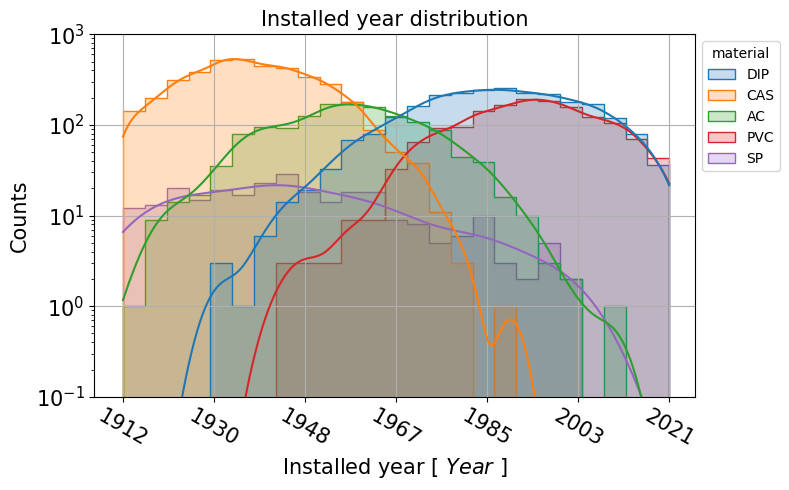

In [71]:
## install year check
min_val = np.nanmin(gm_eda_df['install_time_stamp'])
max_val = np.nanmax(gm_eda_df['install_time_stamp'])
bins = np.linspace(min_val, max_val, 25 + 1)
bin_center = (bins[1:] + bins[:-1]) / 2

## for x tick on the histogram plot
bins_range = np.arange(min_val, max_val + 1, (max_val - min_val) // 6).astype(int) # example timestamp
dt_obj = [datetime.fromtimestamp(bin_r) for bin_r in bins_range] # timestamp to datetime. I didn't consider the timezone
dt_year = [dt.year for dt in dt_obj] # datetime to just year

# plot histogram with KDE
title = 'Installed year distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Installed year [ $Year$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xticks(bins_range, dt_year, rotation=-30)
plt.xlim(min_val * 1.1, max_val * 1.1)
plt.ylim(1e-1, 1e3)
plt.yscale('log')
plt.grid()
ax = sns.histplot(data = gm_eda_df, x= "install_time_stamp", bins = bins, kde = True, hue = "material", element = "step")
#ax = sns.histplot(data = gm_eda_df_new, x= "install_time_date", bins = 50, kde = True, hue = "material", element = "step")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [72]:
## number of missing data points on each meterial type
gm_time_eda_df[['material']].groupby('material').value_counts().to_frame()

,count
material,
CAS,134
DIP,53
PVC,50
SP,30


# Outlier in the diameter column

The range of the diameter in the column starts from 0 to 999 mm. Since 0 mm means there is no volume in the pipe, **the 0 mm is converted to `np.nan`.**

The numerous reference indicates the maximum diameter of Japan's standard water pip is around 600 mm. **The 999 mm is also converted to `np.nan`.**

ref: https://www.yi-her.com/en/stainless-steel-pipe-diameter-size-comparison-table-us-japan-and-german-standard-pipe-outer-diameter/

New diameter column is saved in `diameter_new`.

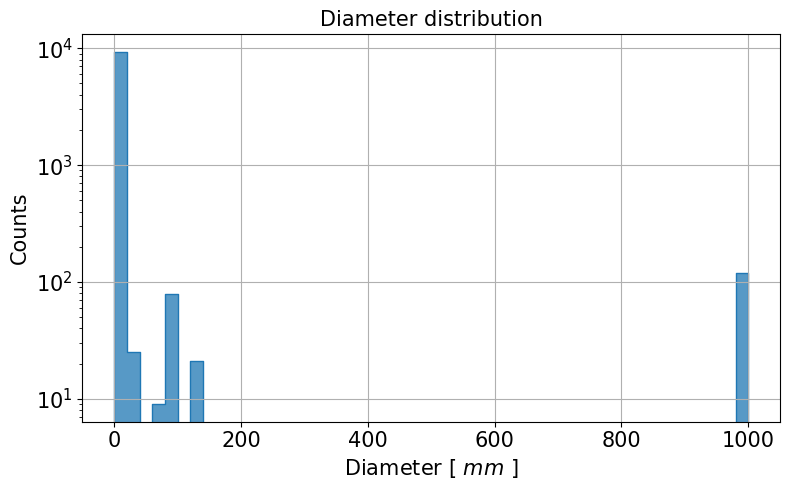

In [73]:
# plot histogram for diameter
bins = np.linspace(0, 1000, 50 + 1)
title = 'Diameter distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Diameter [ $mm$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.yscale('log')
plt.grid()
ax = sns.histplot(data = gm_eda_df, x= "diameter", bins = bins, element = "step")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

In [74]:
## set new diameter column that 0 and 999 mm are nan
gm_eda_df['diameter_new'] = gm_eda_df['diameter'][np.logical_and(gm_eda_df['diameter'] > 1, gm_eda_df['diameter'] < 998)]

## Update the df for addtional missing spots in the data
gm_dia_eda_df = gm_eda_df[gm_eda_df['diameter_new'].isna()]

## number of data points on each diameter.
gm_eda_df[['diameter']].groupby('diameter').value_counts().to_frame()

,count
diameter,
0.0,173
4.0,1795
6.0,2194
8.0,2028
10.0,1378
12.0,888
14.0,550
16.0,296
24.0,18


# Diameter Vs. Shape length

One of the hint of the missing data can be found from relation between `diameter` and `shepe_length`.
The right histogram suggests that **the miss diameter is consistent with the shape length above 650** (Unfortunately, CSV and instruction didn't explain the unit of the shape length). I suspect this is systematic error during the data sourcing or collecting. The distribution below 650 is coming from diameters 0 and 999 mm. which are wrong values.  

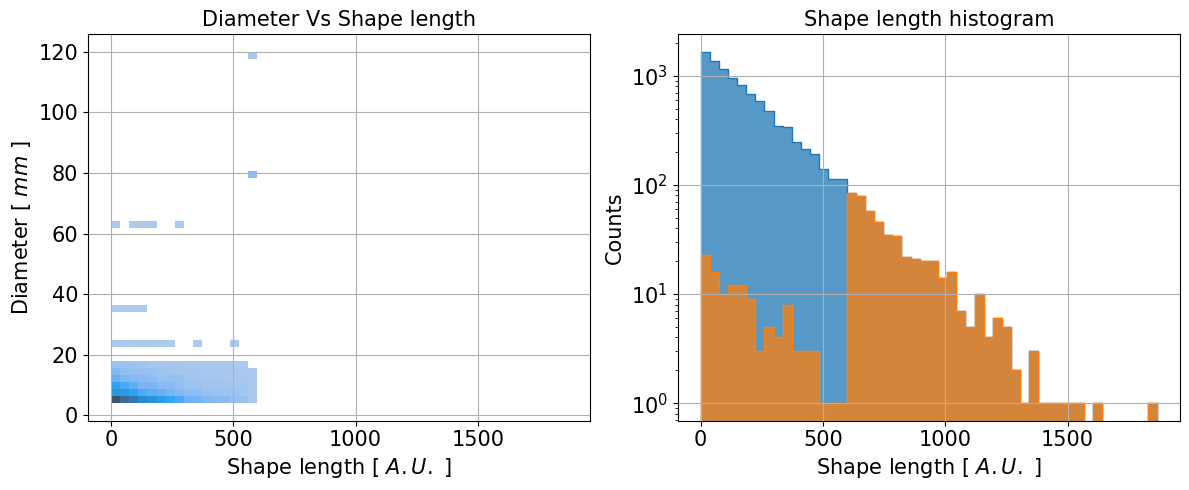

In [75]:
# plot histogram for diameter
dia_bins = np.linspace(np.nanmin(gm_eda_df['diameter_new']), np.nanmax(gm_eda_df['diameter_new']), 50 + 1)
sha_bins = np.linspace(np.nanmin(gm_eda_df['shape_length']), np.nanmax(gm_eda_df['shape_length']), 50 + 1)
title = ['Diameter Vs Shape length', 'Shape length histogram']
xlabel = ['Shape length [ $A.U.$ ]', 'Shape length [ $A.U.$ ]']
ylabel = [r'Diameter [ $mm$ ]', 'Counts']
plt.figure(figsize=(12, 5))

for p in range(2):
  plt.subplot(1, 2, p + 1)
  plt.title(title[p], fontsize = 15)
  plt.xlabel(xlabel[p], fontsize = 15)
  plt.ylabel(ylabel[p], fontsize = 15)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.grid()
  if p == 0:
    sns.histplot(data = gm_eda_df, y= "diameter_new", x = 'shape_length', bins = (sha_bins, dia_bins), element = "step")
  else:
    plt.yscale('log')
    sns.histplot(data = gm_eda_df, x= 'shape_length', bins = sha_bins, element = "step")
    sns.histplot(data = gm_dia_eda_df, x= 'shape_length', bins = sha_bins, element = "step")
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title[0].replace(' ', '_')+'_distribution'
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

# Correlation with missing data columns

There is no significant corelation between the parameters that contain missing rows and other parameters. The relation with mutiple parameters needed ot be check with ML.

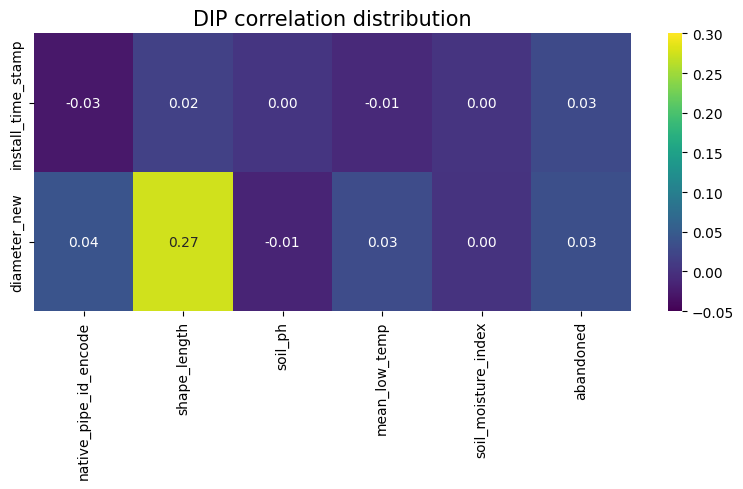

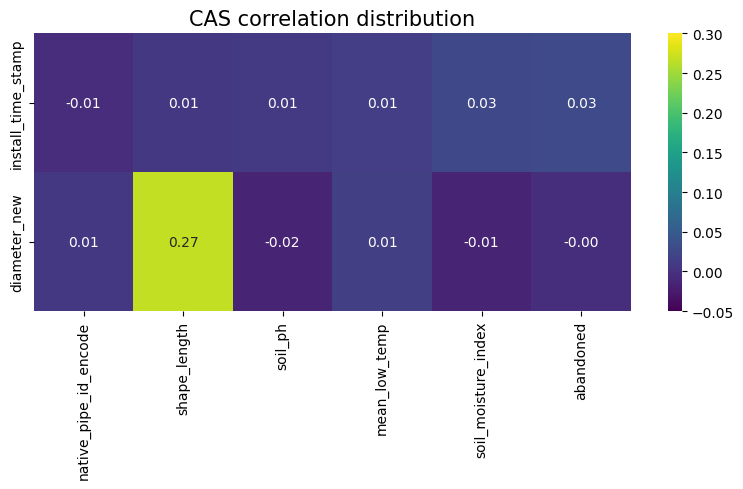

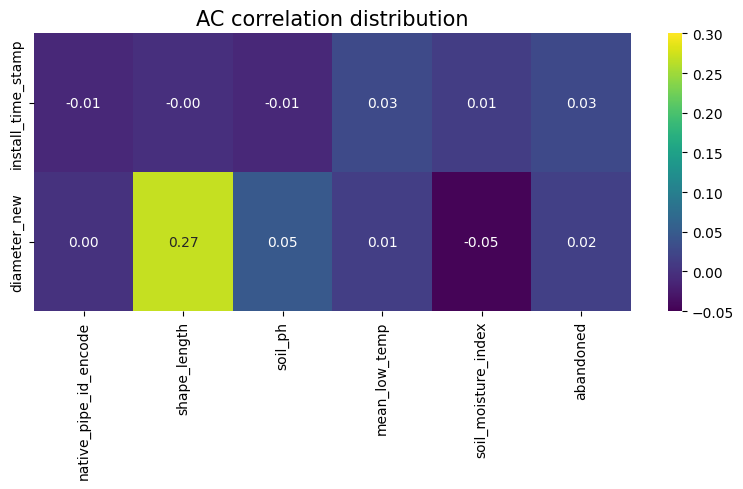

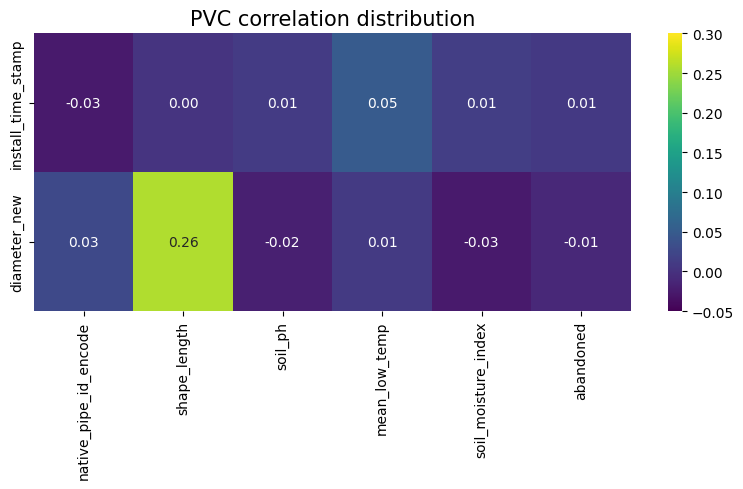

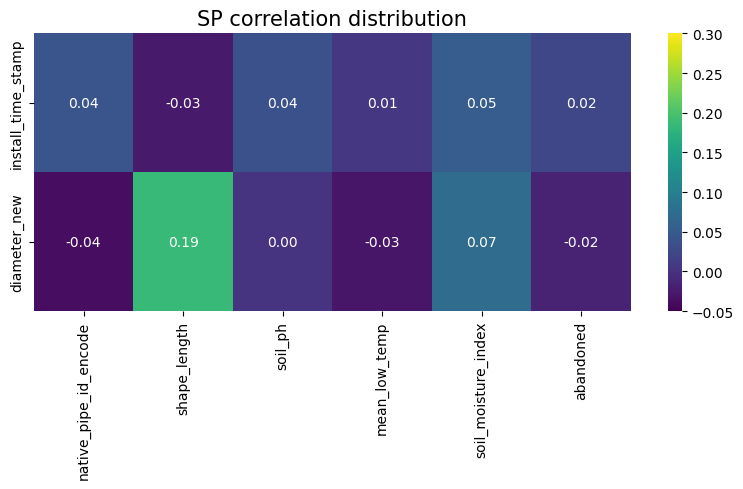

In [76]:
heat_col_list = ['native_pipe_id_encode', 'shape_length', 'soil_ph',
                 'mean_low_temp', 'soil_moisture_index', 'abandoned',
                 'install_time_stamp', 'diameter_new']
gm_heat_df = gm_eda_df[heat_col_list]
for mat in list(gm_eda_df['material'].unique()):
  title = f'{mat} correlation distribution'
  plt.figure(figsize=(8, 5))
  plt.title(title, fontsize = 15)
  sns.heatmap(gm_heat_df[gm_eda_df['material'] == mat].corr().iloc[-2:, :-2], vmin = -0.05, vmax = 0.3, cmap = 'viridis', annot = True, fmt = '.2f')
  #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)
  plt.tight_layout()
  if not os.path.exists(plot_path):
    os.makedirs(plot_path)
  file_name = title.replace(' ', '_')
  plot_name_path = os.path.join(plot_path,f'{file_name}.png')
  plt.savefig(plot_name_path, bbox_inches = 'tight')
  plt.show()
  plt.close()

# WO EDA

1. The `break_date` is converted to time stamp and saved in `break_date_time_stamp`. Now we can utilize date information for analysis.
2. The missing data, which is np.nan, in the `leaking_item` column is converted to 'NULL' and saved in `leaking_item_new`. The total 'NULL' will be considered missing parameter that need to be identified.

In [77]:
## new df for EDA
wo_eda_df = wo_df.copy()

## Converts 'break_date' to unixtime (timestamp) so that I can it for analysis as a numeric format. I din't consider the timezone
wo_eda_df['break_date_time_stamp'] = wo_eda_df['break_date'].apply(lambda x: pd.to_datetime(x).timestamp() if type(x) != float else np.nan)

## converts np.nan to 'NULL'
wo_eda_df['leaking_items_new'] = wo_eda_df['leaking_items'].apply(lambda x: 'NULL' if type(x) == float else x)
wo_eda_df['leaking_items_encode_new'] = label_encoder.fit_transform(wo_eda_df['leaking_items_new'])

# WO and GM merging

1. To check the relation between the information in the GM and WO table, both tables are merged based on their `native_pipe_id`, `install_time_stamp`, and `break_date_time_stamp`
2. Two tables are merged based on `native_pipe_id`, but which `install_year` will be merged with `break_date` is calculated based on their time differences. For example, if `break_date` is 2011 and there are two `install_year`, 1980 and 1950, on the same `native_pipe_id`, I choose 1980 for the merge. The pipe that broke in 2011 is most likely the pip the installed in 1980.

In [78]:
## potential useful information from GM table
gm_col_list = ['native_pipe_id', 'shape_length', 'soil_ph', 'mean_low_temp',
               'soil_moisture_index', 'abandoned', 'material', 'install_year',
               'install_time_stamp', 'diameter_new']
gm_sub_eda_df = gm_eda_df[gm_col_list]
gm_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True) # drop the missing data. We want to learn the relation from data and to fill in the missing part

## bit inefficient way of two table merging
wo_sub_eda_df = wo_eda_df.dropna(subset = 'break_date_time_stamp').copy() # drop the missing data.
wo_sub_eda_df[gm_col_list[1:]] = np.nan # create the empty spot
wo_sub_eda_df.reset_index(inplace = True)
for row in tqdm(range(len(wo_sub_eda_df))):
  id_idx = gm_sub_eda_df['native_pipe_id'] == wo_sub_eda_df['native_pipe_id'][row]
  if np.count_nonzero(id_idx) == 0: continue # if there is no same pipe id in GM table, move on
  gm_ssub_eda_df = gm_sub_eda_df[id_idx]
  diff = wo_sub_eda_df['break_date_time_stamp'][row] - np.asarray(gm_ssub_eda_df['install_time_stamp'])
  diff[diff < 0] = np.nan # install year must be earlier than break date
  if np.count_nonzero(diff < 0) > 0: # check any 'wrong' number in both install year and break date
    print('Wrong date! Need ot be fixed!', wo_sub_eda_df['break_date'][row], gm_ssub_eda_df['install_year'])
  diff_idx = np.nanargmin(diff)
  wo_sub_eda_df.loc[row, gm_col_list[1:]] = gm_ssub_eda_df.iloc[diff_idx, 1:]
wo_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True) # drop the missing data.
wo_sub_eda_df.info()

<ipython-input-78-7202d3dea594>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_sub_eda_df.dropna(subset = 'install_time_stamp', inplace = True) # drop the missing data. We want to learn the relation from data and to fill in the missing part
100%|██████████| 311/311 [00:01<00:00, 255.12it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, 0 to 310
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       305 non-null    int64  
 1   native_pipe_id              305 non-null    object 
 2   leaking_items_original      298 non-null    object 
 3   repair_results              305 non-null    object 
 4   rminfo                      305 non-null    int64  
 5   receipt_date                305 non-null    float64
 6   registration_date_original  305 non-null    int64  
 7   break_date                  305 non-null    object 
 8   leaking_items               298 non-null    object 
 9   leaking_items_encode        305 non-null    int64  
 10  repair_results_encode       305 non-null    int64  
 11  registration_date           305 non-null    object 
 12  break_date_time_stamp       305 non-null    float64
 13  leaking_items_new           305 non-null

# Correlation between two table

There is no significant 1:1 corelation between two tables. The relation with mutiple parameters needed ot be check with ML.

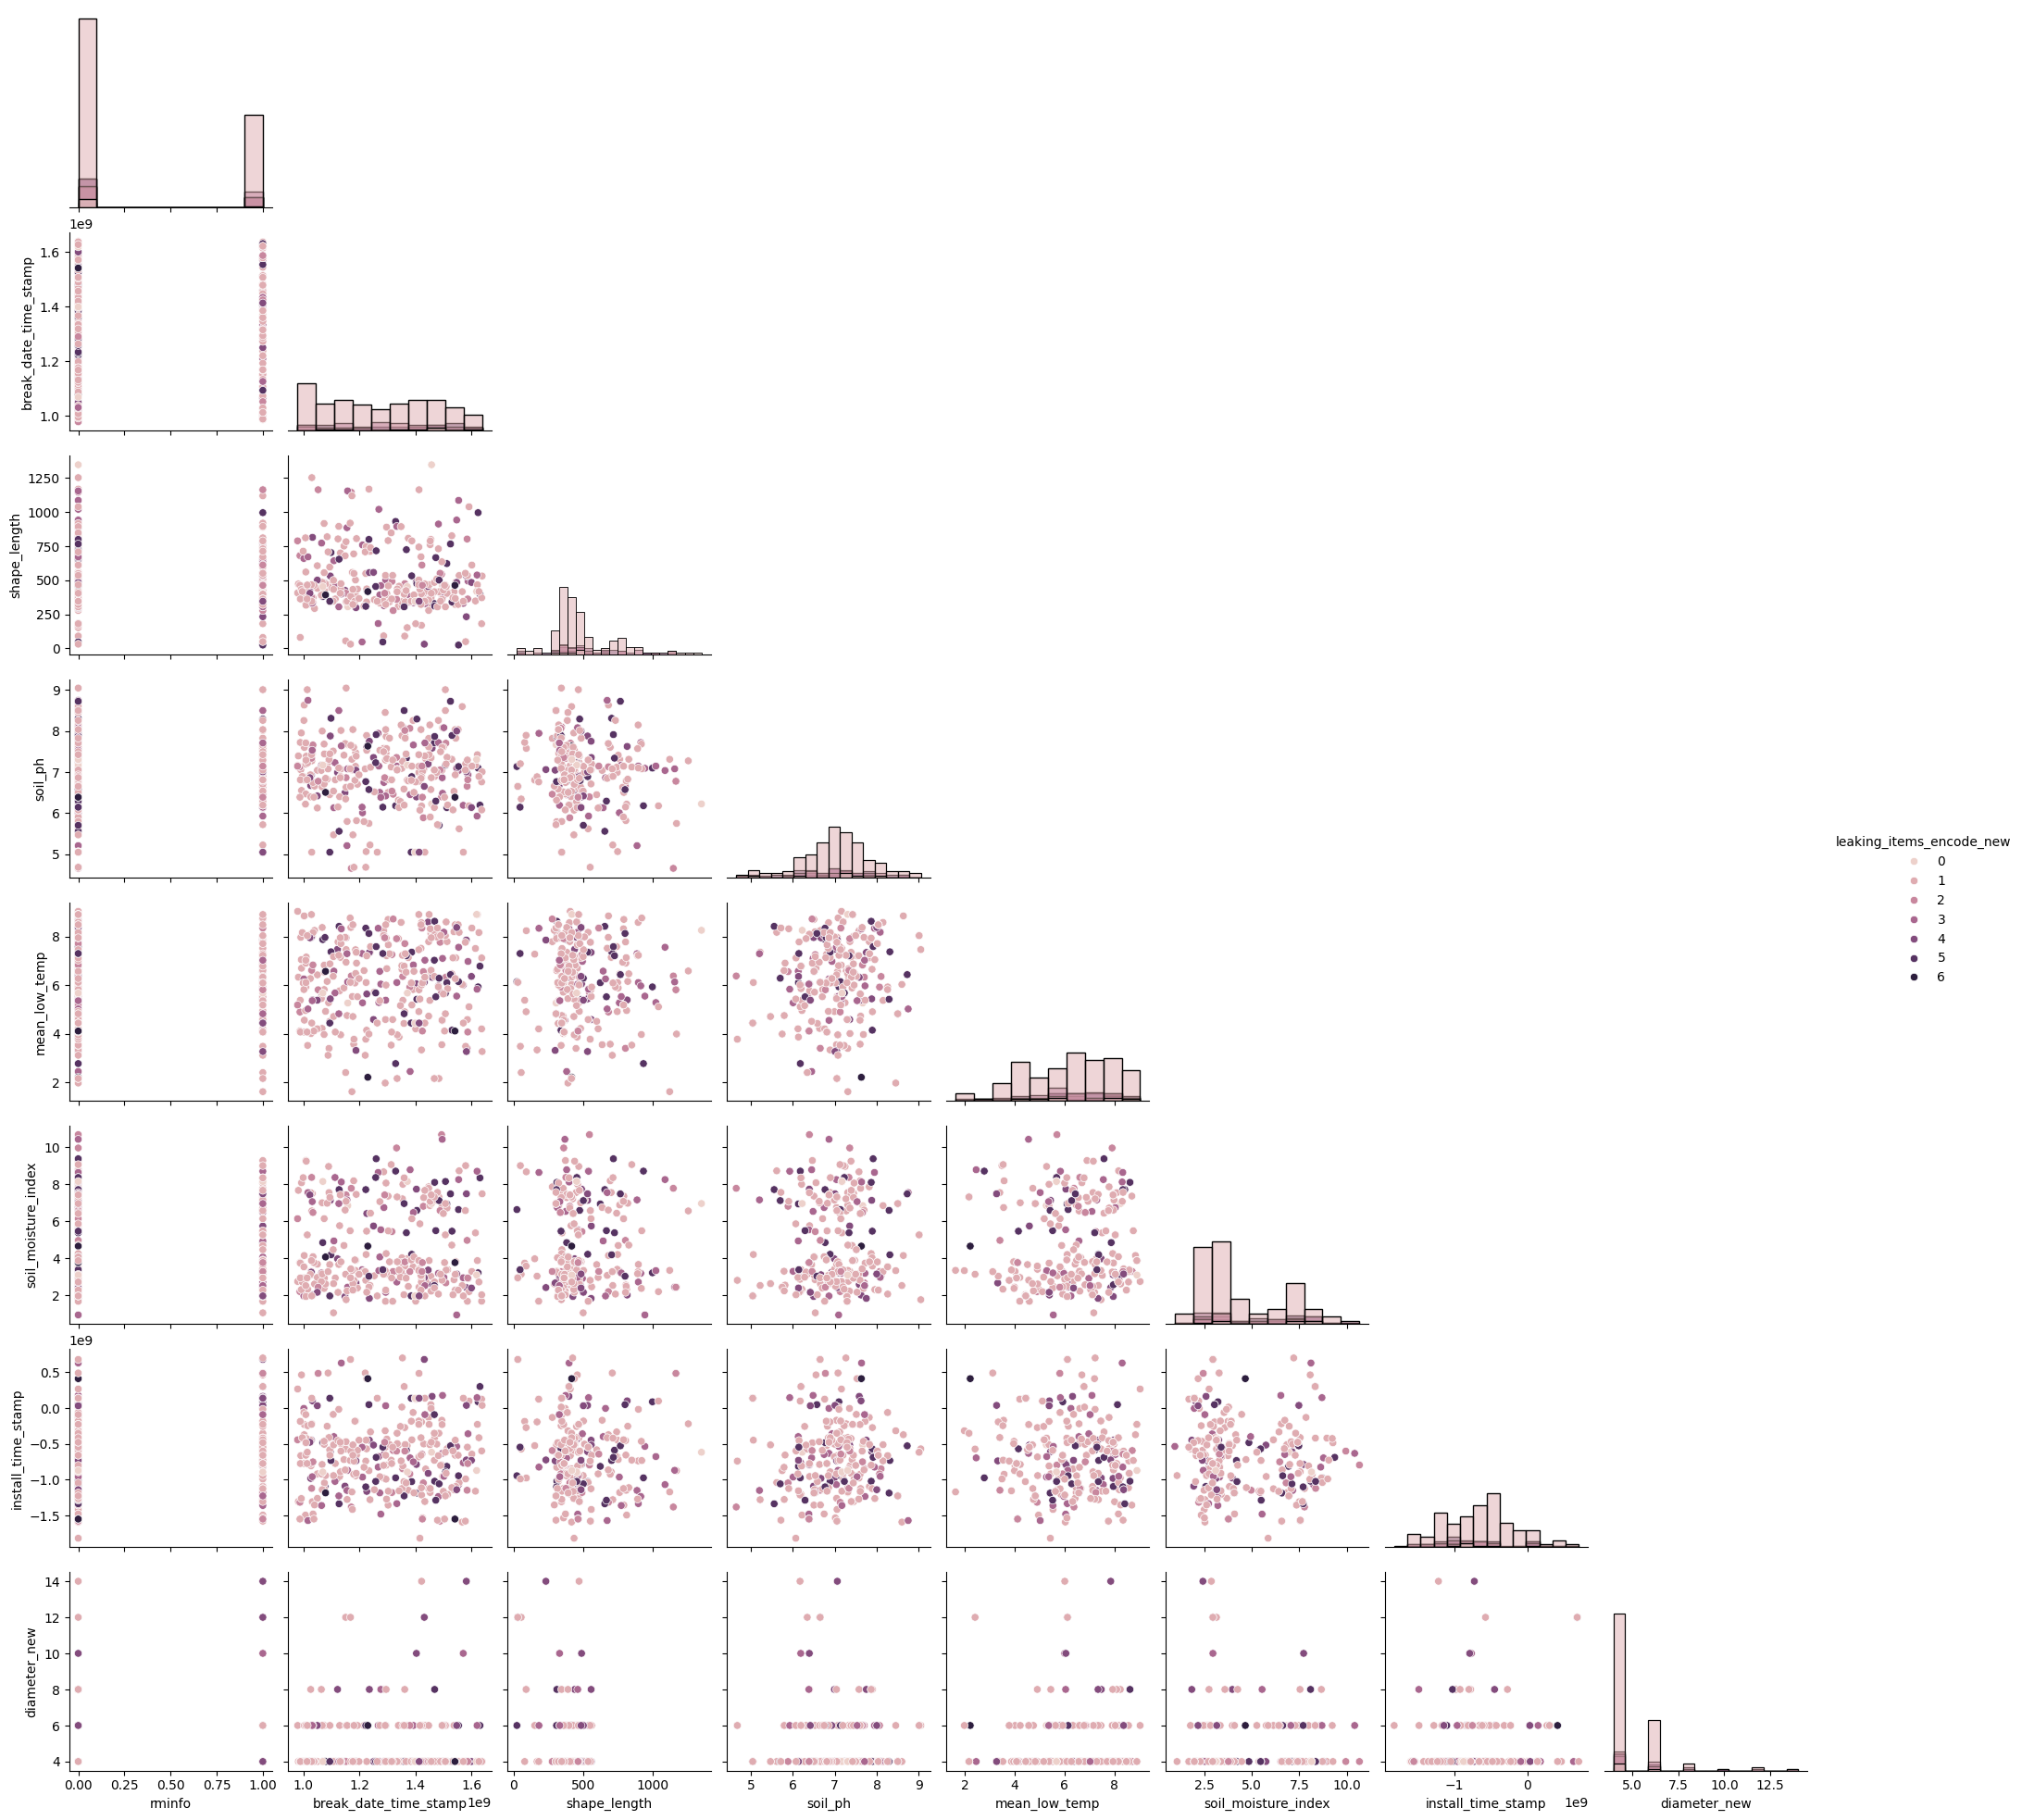

In [79]:
## pair plot between features
sub_col_list = ['rminfo', 'break_date_time_stamp', 'leaking_items_encode_new', 'shape_length',
                'soil_ph', 'mean_low_temp', 'soil_moisture_index', 'install_time_stamp', 'diameter_new']
sns.pairplot(wo_sub_eda_df[sub_col_list], hue = 'leaking_items_encode_new', diag_kind="hist", corner = True)

# Time delta between installed year and first broke date

The time period between the installed year and broke date showed insights.

From the leakage item point of view, median of the all leakage types is populated around **60 ~ 80 years**. In the material types, the AC tends to break around **40 years** after installation and for CAS, it is around **70 years**.

**We can roughly assume that based on their install year we can estimate their breaking time and vice versa.**

In [80]:
## table for calculating time differences between install year and first break date
wo_sub_eda_df['first_break_time'] = wo_sub_eda_df['break_date_time_stamp'] - wo_sub_eda_df['install_time_stamp']
first_df = wo_sub_eda_df.groupby('native_pipe_id')[['material', 'first_break_time', 'break_date', 'install_year', 'leaking_items_new']].min()
first_df['first_break_time_year'] = pd.to_timedelta(first_df['first_break_time'], unit = 's').dt.days / 365 # time differences in year

## table check
first_df

,material,first_break_time,break_date,install_year,leaking_items_new,first_break_time_year
native_pipe_id,,,,,,
WM00040-C,CAS,1.894234e+09,2013-06-10,1953-06-01,crack,60.065753
WM00070-A,AC,2.302646e+09,2012-02-17,1939-03-01,third_party_damage,73.016438
WM00118-A,AC,1.627690e+09,2005-11-28,1954-05-01,crack,51.613699
WM00178-C,CAS,1.632874e+09,2013-02-27,1961-06-01,crack,51.778082
WM00269-A,AC,2.097706e+09,2005-07-23,1939-02-01,pinhole_more_than_5mm,66.517808
...,...,...,...,...,...,...
WM14659-A,AC,1.613866e+09,2015-01-21,1963-12-01,crack,51.175342
WM14666-C,CAS,2.092522e+09,2011-01-22,1944-10-01,crack,66.353425
WM14773-C,CAS,2.196288e+09,2016-07-06,1946-12-01,crack,69.643836


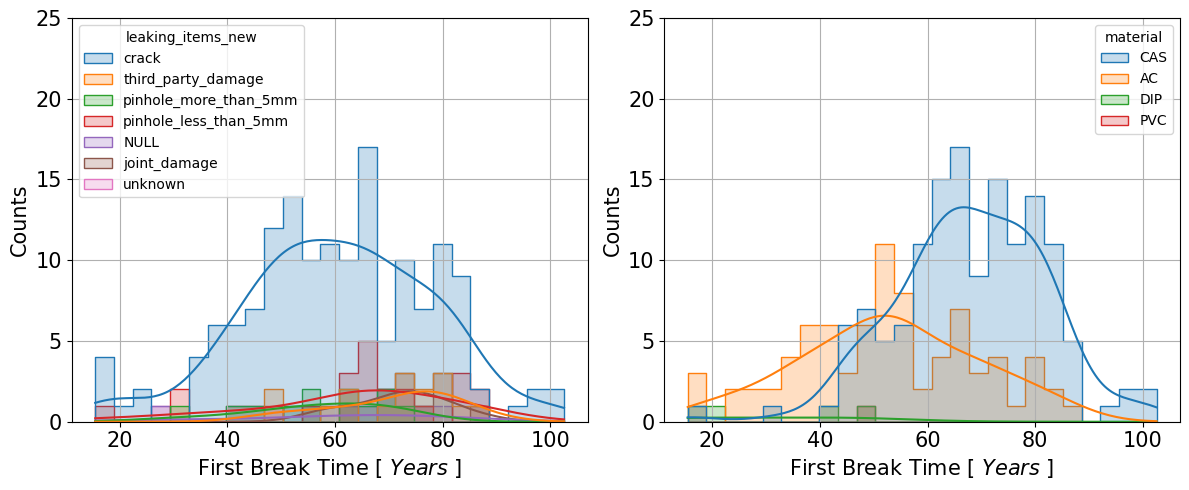

In [81]:
# plot histogram for diameter
fbt_bins = np.linspace(np.nanmin(first_df['first_break_time_year']), np.nanmax(first_df['first_break_time_year']), 25 + 1)
xlabel = ['First Break Time [ $Years$ ]', 'First Break Time [ $Years$ ]']
ylabel = ['Counts', 'Counts']
plt.figure(figsize=(12, 5))

for p in range(2):
  plt.subplot(1, 2, p + 1)
  #plt.title(title[p], fontsize = 15)
  plt.xlabel(xlabel[p], fontsize = 15)
  plt.ylabel(ylabel[p], fontsize = 15)
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=15)
  plt.ylim(0, 25)
  plt.grid()
  if p == 0:
    ax = sns.histplot(data = first_df, x= 'first_break_time_year', kde = True, bins = fbt_bins, hue = 'leaking_items_new', element = "step")
    sns.move_legend(ax, "upper left")
  else:
    sns.histplot(data = first_df, x= 'first_break_time_year', kde = True, bins = fbt_bins, hue = 'material', element = "step")
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = 'First_break_time_distribution'
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

# Time delta between breaks

The time period between the two breaks showed most of the second break will happen around 4 years later. But the number of points are too small to certain the results.

In [82]:
## bit inefficient way of calculating time between two break dates
wo_sub_eda_df2 = wo_eda_df.dropna(subset = 'break_date_time_stamp').copy()
wo_sub_eda_df2.reset_index(inplace = True)
cause_item = []
between_break = []
for row in tqdm(range(len(wo_sub_eda_df2['native_pipe_id'].unique()))):
  id_idx = wo_sub_eda_df2['native_pipe_id'] == wo_sub_eda_df2['native_pipe_id'][row]
  if np.count_nonzero(id_idx) > 1: # if there is more than one break in the same pipe id, we caluclate the time fidderences
    indi_df = wo_sub_eda_df2[['leaking_items_new', 'break_date_time_stamp']][id_idx].sort_values('break_date_time_stamp')
    cause_item += list(indi_df['leaking_items_new'][1:])
    time_np = np.asarray(indi_df['break_date_time_stamp'])
    between_break = np.concatenate((between_break, np.diff(time_np)))

## to date frame and add timediffernces in year
wo_sub_eda_df3 = pd.DataFrame({'cause_item': cause_item, 'between_break': between_break})
wo_sub_eda_df3['between_break_year'] = pd.to_timedelta(wo_sub_eda_df3['between_break'], unit = 's').dt.days / 365

## table check
wo_sub_eda_df3

100%|██████████| 231/231 [00:00<00:00, 1278.03it/s]


,cause_item,between_break,between_break_year
0,pinhole_less_than_5mm,4924800.0,0.156164
1,crack,42163200.0,1.336986
2,pinhole_less_than_5mm,193795200.0,6.145205
3,crack,121996800.0,3.868493
4,crack,221184000.0,7.013699
...,...,...,...
80,crack,42163200.0,1.336986
81,pinhole_less_than_5mm,193795200.0,6.145205
82,crack,121996800.0,3.868493
83,crack,221184000.0,7.013699


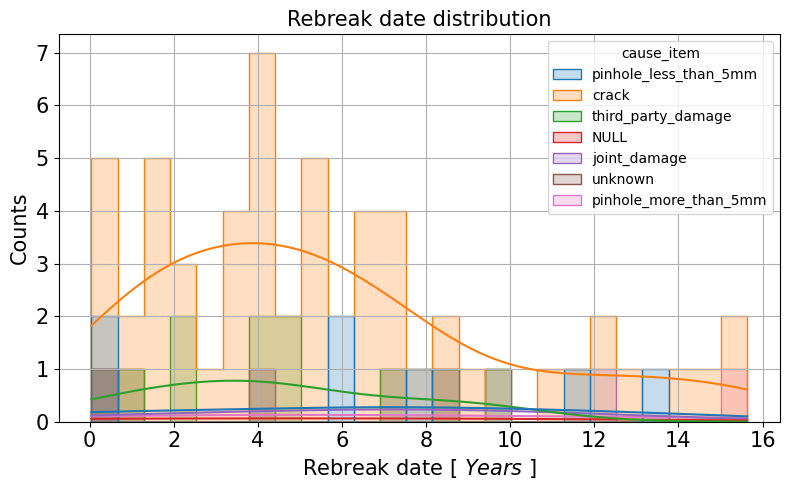

In [83]:
# plot histogram for diameter
fbt_bins = np.linspace(np.nanmin(wo_sub_eda_df3['between_break_year']), np.nanmax(wo_sub_eda_df3['between_break_year']), 25 + 1)
title = 'Rebreak date distribution'
plt.figure(figsize=(8, 5))
plt.title(title, fontsize = 15)
plt.xlabel(r"Rebreak date [ $Years$ ]", fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
#plt.yscale('log')
plt.grid()
ax = sns.histplot(data = wo_sub_eda_df3, x= "between_break_year", kde = True, bins = fbt_bins, hue = 'cause_item', element = "step")
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
if not os.path.exists(plot_path):
  os.makedirs(plot_path)
file_name = title.replace(' ', '_')
plot_name_path = os.path.join(plot_path,f'{file_name}.png')
plt.savefig(plot_name_path, bbox_inches = 'tight')
plt.show()
plt.close()

# EDA conclusion

## Updated information

1. The 0 and 999 mm diameter are converted to np.nan in `diameter` column.
2. The `asset_id` is added on the bothe tables.

## Potential update can be done at the EDA

1. The missing value in `install_year` can be imputed by median value of the each material distribution.
2. The time differences between `install_year` and `break_date` columnes can be uesd for estimating the missing value.
3. Based on time delta between breaks, 'unknown' value in `leaking_items` can be found.

In [84]:
## GM table update based on EDA
gm_eda_fin_df = gm_df.copy()
gm_eda_fin_df['diameter'] = gm_eda_df['diameter_new'].copy()
gm_eda_fin_df['install_year_time_stamp'] = gm_eda_df['install_time_stamp'].copy()
gm_eda_fin_df['asset_id'] = gm_eda_fin_df.index.values.astype(int) + 1

## WO table update based on EDA
wo_eda_fin_df = wo_df.copy()
wo_eda_fin_df['leaking_items'] = wo_eda_df['leaking_items'].copy()
wo_eda_fin_df['leaking_items_encode'] = wo_eda_df['leaking_items_encode'].copy()
wo_eda_fin_df['break_date_time_stamp'] = wo_eda_df['break_date_time_stamp'].copy()

## drop the data related to 'third_party_damage'
wo_eda_fin_df = wo_eda_fin_df.loc[wo_eda_fin_df['leaking_items'] != 'third_party_damage', :]
wo_eda_fin_df.reset_index(inplace = True)

## check the shape
print(gm_eda_fin_df.info(), wo_eda_fin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   native_pipe_id            9876 non-null   object 
 1   material_original         9876 non-null   object 
 2   install_year_original     9609 non-null   object 
 3   shape_length              9876 non-null   float64
 4   diameter                  9263 non-null   float64
 5   usage_status              9876 non-null   bool   
 6   soil_ph                   9876 non-null   float64
 7   mean_low_temp             9876 non-null   float64
 8   soil_moisture_index       9876 non-null   float64
 9   abandoned                 9876 non-null   bool   
 10  material                  9876 non-null   object 
 11  install_year              9609 non-null   object 
 12  material_original_encode  9876 non-null   int64  
 13  material_encode           9876 non-null   int64  
 14  native_p

# ML, miceforest

For filling missing value in the table, I used the miceforest package. It is designed for multiple imputation by chained equations and Random Forest.
ref: https://pypi.org/project/miceforest/2.0.4/

In [85]:
## install miceforest
!pip install miceforest --no-cache-dir

In [86]:
import miceforest as mf

# ML for GM

The filling GM table is done without merging with the WO table. There is a possibility reconstructing the missing values with the WO table can give us better results. Due to size differences between the GM and WO tables which are creating lots of empty spots after the merge, I decided to just use the GM table for GM reconstruction.

In [87]:
## GM df for ml. Use only numerical vaules. We can fill the missing value using reconstructed numerical vaules as an index.
gm_ml_col_list = ['shape_length', 'diameter', 'soil_ph',
                  'mean_low_temp', 'soil_moisture_index', 'abandoned', 'material_encode',
                  'install_year_time_stamp']
gm_ml_df = gm_eda_fin_df[gm_ml_col_list].copy()
gm_ml_df['abandoned'] = gm_ml_df['abandoned'].astype(int) # converts the boolean to integer

## shape check
gm_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   shape_length             9876 non-null   float64
 1   diameter                 9263 non-null   float64
 2   soil_ph                  9876 non-null   float64
 3   mean_low_temp            9876 non-null   float64
 4   soil_moisture_index      9876 non-null   float64
 5   abandoned                9876 non-null   int64  
 6   material_encode          9876 non-null   int64  
 7   install_year_time_stamp  9609 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 617.4 KB


In [88]:
## data into mice format
gm_amp = mf.ampute_data(
    gm_ml_df,         # The data to ampute
    perc = 0.25,      # The percentage of the data to ampute.
    random_state = 42
)

## putting into kernel
kernel = mf.ImputationKernel(
  gm_amp,                     # The data to be imputed.
  save_all_iterations = True, # Save all the imputation values from all iterations. Saving all iterations allows for additional plotting.
  random_state = 42
)

## tune the hyperperemater
optimal_parameters, losses = kernel.tune_parameters(
  dataset = 0,            # The # of dataset to run parameter tuning on
  optimization_steps = 5,  # How many steps to run the process for.
)

## check the tuned hyperperemater
print(optimal_parameters)
#for param in optimal_parameters[0]:
#  print(f'{param}: {optimal_parameters[0][param]}')

## Run mice with tuned parameters.
kernel.mice(1, variable_parameters = optimal_parameters)

## fill the missing value
gm_ml_mice_df = kernel.complete_data()
gm_ml_mice_df.info()

{0: {'boosting': 'gbdt', 'num_iterations': 44, 'max_depth': 8, 'num_leaves': 11, 'min_data_in_leaf': 207, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9382692950137539, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7150026531521925, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 6.561507785017085}, 2: {'boosting': 'gbdt', 'num_iterations': 6, 'max_depth': 8, 'num_leaves': 19, 'min_data_in_leaf': 357, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9462845379153378, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.3643087720225926, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 10.392589457123226}, 3: {'boosting': 'gbdt', 'num_iterations': 2, 'max_depth': 8, 'num_leaves': 10, 'min_data_in_leaf': 166, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.41755970653615004, 'featu

# Filling missing values into GM table

The missing values in `diameter` and `install_year` are replaced with the reconstructed (predicted) values.

In [89]:
## final df by ML
gm_ml_fin_df = gm_eda_fin_df.copy()

## nan locations
dia_nan_idx = gm_eda_fin_df['diameter'].isna()
inyr_nan_idx = gm_eda_fin_df['install_year_time_stamp'].isna()

## reco time stamp to year
gm_ml_mice_df['install_year'] = gm_ml_mice_df['install_year_time_stamp'].apply(lambda x: pd.to_datetime(x, unit='s')).astype(str)

## swap
gm_ml_fin_df.loc[dia_nan_idx, 'diameter'] = gm_ml_mice_df.loc[dia_nan_idx, 'diameter']
gm_ml_fin_df.loc[inyr_nan_idx, 'install_year_time_stamp'] = gm_ml_mice_df.loc[inyr_nan_idx, 'install_year_time_stamp']
gm_ml_fin_df.loc[inyr_nan_idx, 'install_year'] = gm_ml_mice_df.loc[inyr_nan_idx, 'install_year']

## shape check
gm_ml_fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876 entries, 0 to 9875
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   native_pipe_id            9876 non-null   object 
 1   material_original         9876 non-null   object 
 2   install_year_original     9609 non-null   object 
 3   shape_length              9876 non-null   float64
 4   diameter                  9876 non-null   float64
 5   usage_status              9876 non-null   bool   
 6   soil_ph                   9876 non-null   float64
 7   mean_low_temp             9876 non-null   float64
 8   soil_moisture_index       9876 non-null   float64
 9   abandoned                 9876 non-null   bool   
 10  material                  9876 non-null   object 
 11  install_year              9876 non-null   object 
 12  material_original_encode  9876 non-null   int64  
 13  material_encode           9876 non-null   int64  
 14  native_p

# Metric

Red is true and black line is reconstructed value.

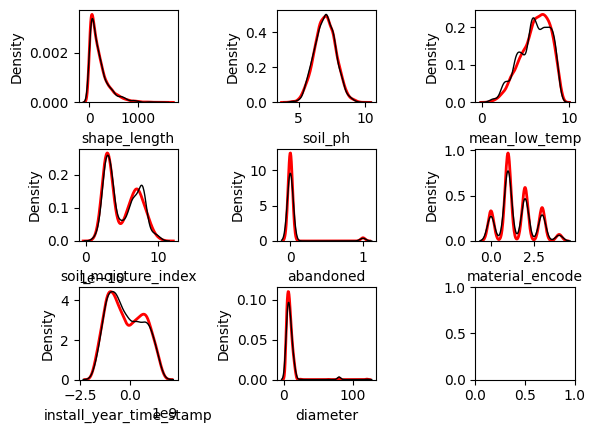

In [90]:
kernel.plot_imputed_distributions(wspace = 1, hspace = 0.5)

# Feacture importance

As we observed in the EDA, the reconstructed installed year is correlated with the material type.

Axes(0.125,0.11;0.62x0.77)


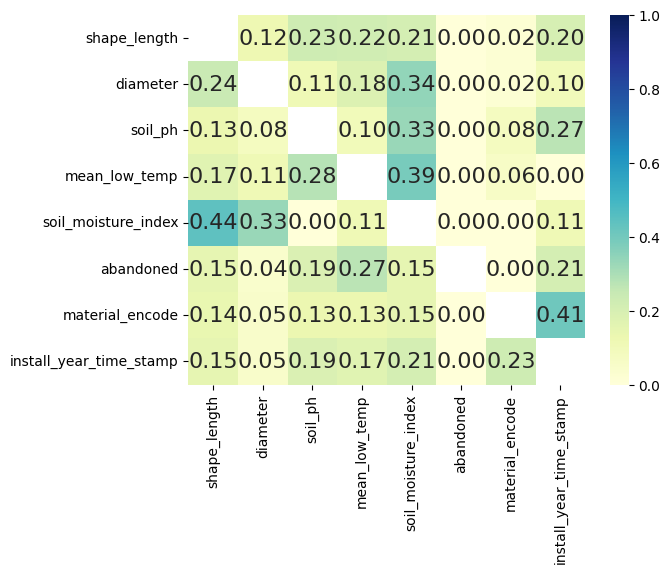

In [91]:
kernel.plot_feature_importance(dataset = 0, annot = True, cmap = "YlGnBu", vmin = 0, vmax = 1)

# ML for WO

The filling WO table is done with the GM table. The number of features in the WO table is not good enough for reconstruction. The EDA also showed the installed year and material type have a correlation with the break date. The merging with the GM table is done by choosing the closest installed year to the break date and the pipe ID.

In [92]:
## WO df for ml
gm_ml_col_list = ['native_pipe_id', 'asset_id'] + list(gm_ml_df.columns)
gm_ml_sub_df = gm_ml_fin_df[gm_ml_col_list].copy()
gm_ml_sub_df['abandoned'] = gm_ml_sub_df['abandoned'].astype(int)

wo_ml_col_list = ['native_pipe_id', 'rminfo', 'leaking_items_encode', 'break_date_time_stamp']
wo_ml_df = wo_eda_fin_df[wo_ml_col_list].copy()

# bit inefficient way of two table merging
wo_ml_df[gm_ml_col_list[1]] = 0 # create the empty spot
wo_ml_df[gm_ml_col_list[2:]] = np.nan # create the empty spot
for row in tqdm(range(len(wo_ml_df))):
  id_idx = gm_ml_sub_df['native_pipe_id'] == wo_ml_df['native_pipe_id'][row]
  gm_ssub_eda_df = gm_ml_sub_df[id_idx]
  b_time = wo_ml_df['break_date_time_stamp'][row]
  i_time = np.asarray(gm_ssub_eda_df['install_year_time_stamp'])
  diff = b_time - i_time
  diff[diff < 0] = np.nan
  if np.count_nonzero(diff < 0) > 0: # check any 'wrong' number in both install year and break date
    print('Wrong date! Need ot be fixed!', wo_ml_df['break_date'][row], gm_ssub_eda_df['install_year'])
  if np.isnan(b_time): # if break_date is NaN choose most recent install year for merging
    diff_idx = np.nanargmax(i_time)
  else:
    diff_idx = np.nanargmin(diff)
  wo_ml_df.loc[row, gm_ml_col_list[1:]] = gm_ssub_eda_df.iloc[diff_idx, 1:]
wo_ml_df.info()

100%|██████████| 311/311 [00:04<00:00, 72.68it/s] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   native_pipe_id           311 non-null    object 
 1   rminfo                   311 non-null    int64  
 2   leaking_items_encode     311 non-null    int64  
 3   break_date_time_stamp    284 non-null    float64
 4   asset_id                 311 non-null    int64  
 5   shape_length             311 non-null    float64
 6   diameter                 311 non-null    float64
 7   soil_ph                  311 non-null    float64
 8   mean_low_temp            311 non-null    float64
 9   soil_moisture_index      311 non-null    float64
 10  abandoned                311 non-null    float64
 11  material_encode          311 non-null    float64
 12  install_year_time_stamp  311 non-null    float64
dtypes: float64(9), int64(3), object(1)
memory usage: 31.7+ KB


In [93]:
## WO df for ml. Use only numerical vaules. We can fill the missing value using reconstructed numerical vaules as an index.
wo_mine_col_list = ['rminfo', 'leaking_items_encode', 'break_date_time_stamp', 'shape_length',
                    'diameter', 'soil_ph', 'mean_low_temp', 'soil_moisture_index', 'abandoned', 'material_encode', 'install_year_time_stamp']
wo_temp_df = wo_ml_df[wo_mine_col_list].copy()
wo_temp_df['leaking_items_encode'] = wo_temp_df['leaking_items_encode'].astype(float)
wo_temp_nan_idx = wo_eda_fin_df['leaking_items'].isna()
wo_temp_df['leaking_items_encode'][wo_temp_nan_idx] = np.nan
wo_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rminfo                   311 non-null    int64  
 1   leaking_items_encode     304 non-null    float64
 2   break_date_time_stamp    284 non-null    float64
 3   shape_length             311 non-null    float64
 4   diameter                 311 non-null    float64
 5   soil_ph                  311 non-null    float64
 6   mean_low_temp            311 non-null    float64
 7   soil_moisture_index      311 non-null    float64
 8   abandoned                311 non-null    float64
 9   material_encode          311 non-null    float64
 10  install_year_time_stamp  311 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 26.9 KB


<ipython-input-93-d60375c6b92e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_temp_df['leaking_items_encode'][wo_temp_nan_idx] = np.nan


In [132]:
## data into mice format
wo_amp = mf.ampute_data(
    wo_temp_df,         # The data to ampute
    perc = 0.25,      # The percentage of the data to ampute.
    random_state = 42
)

## putting into kernel
kernel = mf.ImputationKernel(
  wo_temp_df,                     # The data to be imputed.
  save_all_iterations = True, # Save all the imputation values from all iterations. Saving all iterations allows for additional plotting.
  random_state = 42
)

## tune the hyperperemater
optimal_parameters, losses = kernel.tune_parameters(
  dataset = 0,            # The # of dataset to run parameter tuning on
  optimization_steps = 5,  # How many steps to run the process for.
)

## The optimal parameters are kept in ImputationKernel.optimal_parameters:
print(optimal_parameters)
#for param in optimal_parameters[0]:
#  print(f'{param}: {optimal_parameters[0][param]}')

{1: {'boosting': 'gbdt', 'num_iterations': 19, 'max_depth': 8, 'num_leaves': 23, 'min_data_in_leaf': 29, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.827557613304815, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.3741523922560336, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 2.441802850159597}, 2: {'boosting': 'gbdt', 'num_iterations': 6, 'max_depth': 8, 'num_leaves': 8, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.5108811134346193, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.2965963934951502, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'learning_rate': 0.02, 'cat_smooth': 10.412748696759156}}


In [164]:
## Run mice with our newly tuned parameters.
kernel.mice(3, variable_parameters = optimal_parameters)

## fill the missing value
wo_ml_mice_df = kernel.complete_data()
wo_ml_mice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rminfo                   311 non-null    int64  
 1   leaking_items_encode     311 non-null    float64
 2   break_date_time_stamp    311 non-null    float64
 3   shape_length             311 non-null    float64
 4   diameter                 311 non-null    float64
 5   soil_ph                  311 non-null    float64
 6   mean_low_temp            311 non-null    float64
 7   soil_moisture_index      311 non-null    float64
 8   abandoned                311 non-null    float64
 9   material_encode          311 non-null    float64
 10  install_year_time_stamp  311 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 26.9 KB


# Metric

Red is true and black line is reconstructed value.



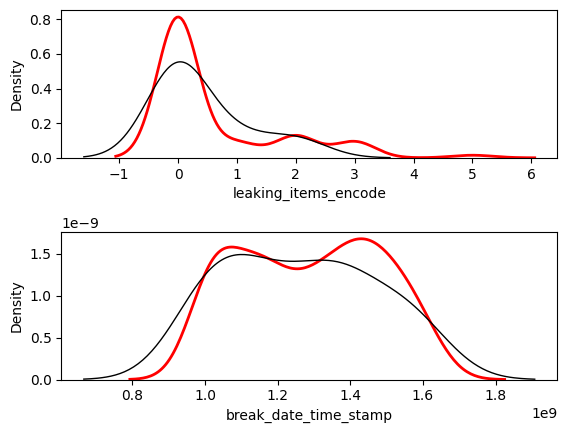

In [167]:
kernel.plot_imputed_distributions(wspace = 1, hspace = 0.5)

# Feacture importance

As we observed in the EDA, the reconstructed installed year is correlated with the break date.

Axes(0.125,0.11;0.62x0.77)


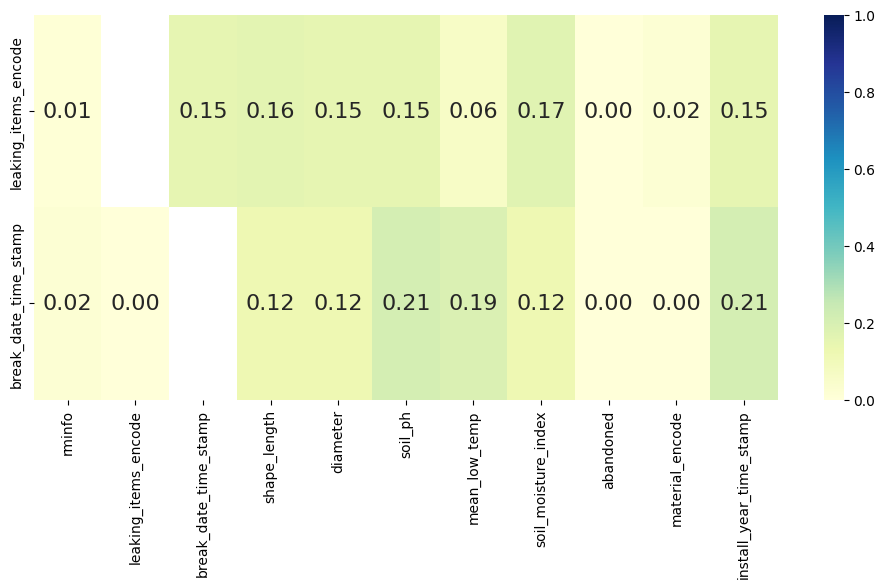

In [168]:
plt.figure(figsize=(12, 5))
kernel.plot_feature_importance(dataset = 0, annot = True, cmap = "YlGnBu", vmin = 0, vmax = 1)

# Filling missing values into WO table

The missing values in `break_date` and `leaking_items` are replaced with the reconstructed (predicted) values. Ans the `asset_id` is added into table.

In [170]:
## final df by ML
wo_ml_fin_df = wo_eda_fin_df.copy()
wo_ml_fin_df['asset_id'] = wo_ml_df['asset_id'].copy()

## nan locations
bdt_nan_idx = wo_eda_fin_df['break_date_time_stamp'].isna()
li_nan_idx = wo_eda_fin_df['leaking_items'].isna()

## reco time stamp to year
wo_ml_mice_df['break_date'] = wo_ml_mice_df['break_date_time_stamp'].apply(lambda x: pd.to_datetime(x, unit='s')).astype(str)
li_dict = {0:'crack', 1:'joint_damage', 2:'pinhole_less_than_5mm', 3:'pinhole_more_than_5mm', 5:'unknown'}
wo_ml_mice_df['leaking_items'] = wo_ml_mice_df['leaking_items_encode'].astype(int).map(li_dict)

## swap
wo_ml_fin_df.loc[bdt_nan_idx, 'break_date'] = wo_ml_mice_df.loc[bdt_nan_idx, 'break_date']
wo_ml_fin_df.loc[bdt_nan_idx, 'break_date_time_stamp'] = wo_ml_mice_df.loc[bdt_nan_idx, 'break_date_time_stamp']
wo_ml_fin_df.loc[li_nan_idx, 'leaking_items_encode'] = wo_ml_mice_df.loc[li_nan_idx, 'leaking_items_encode'].astype(int)
wo_ml_fin_df.loc[li_nan_idx, 'leaking_items'] = wo_ml_mice_df.loc[li_nan_idx, 'leaking_items']
wo_ml_fin_df.drop('index', axis=1, inplace = True)

## shape check
wo_ml_fin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   native_pipe_id              311 non-null    object 
 1   leaking_items_original      304 non-null    object 
 2   repair_results              311 non-null    object 
 3   rminfo                      311 non-null    int64  
 4   receipt_date                284 non-null    float64
 5   registration_date_original  311 non-null    int64  
 6   break_date                  311 non-null    object 
 7   leaking_items               311 non-null    object 
 8   leaking_items_encode        311 non-null    int64  
 9   repair_results_encode       311 non-null    int64  
 10  registration_date           311 non-null    object 
 11  break_date_time_stamp       311 non-null    float64
 12  asset_id                    311 non-null    int64  
dtypes: float64(2), int64(5), object(6)


In [171]:
## save the results. Output is in '/output' path
gm_ml_fin_df.to_csv(os.path.join(output_path, 'Pipe.csv'), index = False)
wo_ml_fin_df.to_csv(os.path.join(output_path, 'Break.csv'), index = False)